In [1]:
class EchoStateNetworkSingle:
    def __init__(self, n_inputs, n_outputs,
                 n_res_fast=180, n_res_slow=100,
                 sr_fast=0.95, sr_slow=0.75,
                 sparsity=0.9, leak_fast=0.3, leak_slow=0.15,
                 input_scaling=1.0, add_input_to_readout=True,
                 noise=0.0, ridge_alpha=1e-2, random_state=42):

        self.n_inputs, self.n_outputs = n_inputs, n_outputs
        self.add_input_to_readout = add_input_to_readout
        self.ridge_alpha, self.noise = ridge_alpha, noise
        self.rng = np.random.RandomState(random_state)

        def init_res(n_res, sr, leak):
            Win = (self.rng.rand(n_res, n_inputs) - 0.5) * 2.0 * input_scaling
            W = self.rng.rand(n_res, n_res) - 0.5
            W[self.rng.rand(n_res, n_res) < sparsity] = 0.0
            eigmax = np.max(np.abs(np.linalg.eigvals(W))) or 1e-6
            return Win, (W / eigmax) * sr, leak

        self.Win_f, self.W_f, self.leak_f = init_res(n_res_fast, sr_fast, leak_fast)
        self.Win_s, self.W_s, self.leak_s = init_res(n_res_slow, sr_slow, leak_slow)

        self.readout = Ridge(alpha=self.ridge_alpha, fit_intercept=False)

    def _run(self, X):
        T = X.shape[0]
        xf = np.zeros(self.Win_f.shape[0])
        xs = np.zeros(self.Win_s.shape[0])
        states = np.zeros((T, xf.size + xs.size))

        for t in range(T):
            xf = (1 - self.leak_f) * xf + self.leak_f * np.tanh(self.Win_f @ X[t] + self.W_f @ xf)
            xs = (1 - self.leak_s) * xs + self.leak_s * np.tanh(self.Win_s @ X[t] + self.W_s @ xs)

            if self.noise:
                xf += self.noise * self.rng.randn(*xf.shape)
                xs += self.noise * self.rng.randn(*xs.shape)

            states[t] = np.concatenate([xf, xs])

        return states

    # ======================================================
    # FIT on SEQUENCES
    # ======================================================
    def fit_sequence(self, X_seq, Y_seq):
        """
        X_seq: (N_seq, SEQ, D)
        Y_seq: (N_seq, 1)
        """
        feats = []

        for i in range(len(X_seq)):
            S = self._run(X_seq[i])        # (SEQ, res_dim)
            last_state = S[-1]             # take last state

            parts = [last_state]
            if self.add_input_to_readout:
                parts.append(X_seq[i, -1]) # last input vector
            parts.append(np.ones(1))       # bias

            feats.append(np.concatenate(parts))

        Phi = np.vstack(feats)             # (N_seq, F)
        self.readout.fit(Phi, Y_seq)

    # ======================================================
    # PREDICT on SEQUENCES
    # ======================================================
    def predict_sequence(self, X_seq):
        feats = []

        for i in range(len(X_seq)):
            S = self._run(X_seq[i])
            last_state = S[-1]

            parts = [last_state]
            if self.add_input_to_readout:
                parts.append(X_seq[i, -1])
            parts.append(np.ones(1))

            feats.append(np.concatenate(parts))

        Phi = np.vstack(feats)
        return self.readout.predict(Phi)

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle
import cvxpy as cp
import random 
import tensorflow as tf

plt.style.use("seaborn-v0_8")

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [3]:
file_path = r"E:\models\ESN_Model1\ESN_Model1.pkl"
with open(file_path, "rb") as f:
    data = pickle.load(f)

models    = data["models"]
scX       = data["scX"]
scY       = data["scY"]
assets    = data["assets"]
LAGS      = data["LAGS"]
SEQ       = data["SEQ"]
X_columns = data["X_columns"]

print("Loaded:", len(assets), "assets | LAGS:", LAGS, "| SEQ:", SEQ)

df = pd.read_csv(r"E:\data\stock_prices.csv", index_col="date", parse_dates=True).sort_index()

# Monthly dataset for classic strategies (κοινό benchmark)
px_monthly = df.resample("ME").last()
retm_assets = px_monthly.pct_change().dropna()

print("Monthly dataset shape:", retm_assets.shape)

Loaded: 10 assets | LAGS: 11 | SEQ: 5
Monthly dataset shape: (93, 10)


c:\Users\zedax\AppData\Local\r-miniconda\envs\r-reticulate\lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.7.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\zedax\AppData\Local\r-miniconda\envs\r-reticulate\lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
# ============================================================
# 3. FEATURE PIPELINE (same as training)
# ============================================================
def compute_returns(px_df, kind="log"):
    return (np.log(px_df).diff() if kind=="log" else px_df.pct_change()).dropna()

def realized_vol(ret_df, window=20):
    return ret_df.rolling(window, min_periods=window).std()

def add_time_lags_df(df_in, lags=5, name_suffix=""):
    parts = [df_in.shift(k).add_suffix(f"{name_suffix}_t-{k}") for k in range(1, lags+1)]
    return pd.concat(parts, axis=1)

def build_features_target_next_price(px_df, lags=5, vol_windows=(5,20), include_level=True):
    ret = compute_returns(px_df, "log")
    px_aligned = px_df.loc[ret.index]

    X_ret = add_time_lags_df(ret, lags=lags, name_suffix="_r")
    X_vol = pd.concat([
        add_time_lags_df(realized_vol(ret, w), lags=min(3,lags), name_suffix=f"_vol{w}")
        for w in vol_windows
    ], axis=1)

    mkt_vol = realized_vol(ret, window=vol_windows[0]).median(axis=1)
    q = mkt_vol.quantile([0.33, 0.66])

    X_reg = pd.concat([
        (mkt_vol <= q.iloc[0]).astype(int).rename("reg_low"),
        ((mkt_vol > q.iloc[0]) & (mkt_vol <= q.iloc[1])).astype(int).rename("reg_mid"),
        (mkt_vol > q.iloc[1]).astype(int).rename("reg_high")
    ], axis=1)

    parts = [X_ret, X_vol, X_reg]
    if include_level:
        X_lvl = add_time_lags_df(px_aligned - px_aligned.mean(), lags=min(2,lags), name_suffix="_lvl")
        parts.append(X_lvl)

    X = pd.concat(parts, axis=1).dropna()
    Y_next = px_aligned.shift(-1).reindex(X.index).dropna()
    X = X.loc[Y_next.index]
    return X, Y_next

def make_sequence_windows(X, seq_len):
    X = np.asarray(X)
    T = X.shape[0]
    out = []
    for i in range(T - seq_len):
        out.append(X[i:i+seq_len])
    return np.stack(out, axis=0)

# Build full features
X_full_df, _ = build_features_target_next_price(df, lags=LAGS)

# Enforce exact column order used in training
X_full_df = X_full_df[X_columns]

# Scale with training scalers
X_full_sc = scX.transform(X_full_df)

# Make sequences (T-SEQ, SEQ, D)
X_full_seq = make_sequence_windows(X_full_sc, SEQ)

idx_full = X_full_df.index
idx_seq  = idx_full[SEQ:]  # length = T - SEQ

print("X_full_df:", X_full_df.shape, "| X_full_seq:", X_full_seq.shape, "| idx_seq:", len(idx_seq))

X_full_df: (1926, 193) | X_full_seq: (1921, 5, 193) | idx_seq: 1921


In [5]:
T_seq = X_full_seq.shape[0]
n_assets = len(assets)

Y_hat_sc = np.zeros((T_seq, n_assets), dtype=float)

for j, a in enumerate(assets):
    m = models[a]
    yhat = m.predict_sequence(X_full_seq)  # (T_seq, 1) or (T_seq,)
    yhat = np.asarray(yhat).reshape(-1, 1) # enforce 2D
    Y_hat_sc[:, j] = yhat.ravel()

# Inverse-scale predicted next prices P_{t+1}
Y_hat = scY.inverse_transform(Y_hat_sc)

# Align prices to idx_seq (t corresponds to idx_seq)
P_t      = df[assets].loc[idx_seq].values
P_t1_real = df[assets].shift(-1).loc[idx_seq].values

# Forecast & realized returns (H+1)
r_hat = (Y_hat - P_t) / P_t
r_real = (P_t1_real - P_t) / P_t

r_hat_df  = pd.DataFrame(r_hat,  index=idx_seq, columns=assets)
r_real_df = pd.DataFrame(r_real, index=idx_seq, columns=assets)

# Drop last NaN row(s) due to shift(-1)
common_idx = r_hat_df.dropna().index.intersection(r_real_df.dropna().index)
r_hat_df  = r_hat_df.loc[common_idx]
r_real_df = r_real_df.loc[common_idx]

print("r_hat_df:", r_hat_df.shape, "| r_real_df:", r_real_df.shape)

rets_all = df[assets].pct_change().dropna()

r_hat_df: (1921, 10) | r_real_df: (1921, 10)


In [6]:
def make_psd(S, eps=1e-8):
    """Project symmetric matrix to PSD by clipping eigenvalues."""
    S = 0.5 * (S + S.T)
    w, V = np.linalg.eigh(S)
    w = np.maximum(w, eps)
    return (V * w) @ V.T

def markowitz_minvar(mu, Sigma, allow_short=True, target_return=None, w_bounds=None):

    n = len(mu)
    w = cp.Variable(n)

    cons = [cp.sum(w) == 1]
    if not allow_short:
        cons.append(w >= 0)
    if w_bounds is not None:
        lb, ub = w_bounds
        cons += [w >= lb, w <= ub]
    if target_return is not None:
        cons.append(mu @ w >= target_return)

    prob = cp.Problem(cp.Minimize(cp.quad_form(w, Sigma)), cons)
    prob.solve(solver=cp.OSQP, verbose=False)  

    if w.value is None:
        return np.ones(n) / n

    return np.array(w.value).ravel()

# ============================================================
# 8. ROLLING ESN → MARKOWITZ (H+1, daily rebalance)
# ============================================================
def rolling_esn_markowitz_H1(
    r_hat_df, r_real_df, rets_all,
    lookback=252,
    allow_short=True,
    use_return_constraint=True,
    w_bounds=(-0.2, 0.2), 
    ddof=0
):
    rec = []
    for t in r_hat_df.index:
        # strict past covariance up to t-1
        hist = rets_all.loc[:t].iloc[:-1].tail(lookback)
        if hist.shape[0] < lookback:
            continue
        if t not in r_real_df.index:
            continue

        mu = r_hat_df.loc[t].values.astype(float)

        Sigma = hist.cov(ddof=ddof).values
        if np.any(~np.isfinite(mu)) or np.any(~np.isfinite(Sigma)):
            continue

        Sigma = make_psd(Sigma, eps=1e-8)

        target = float(mu.mean()) if use_return_constraint else None
        bounds = w_bounds if allow_short else None

        w = markowitz_minvar(mu, Sigma, allow_short, target, bounds)

        r_next = r_real_df.loc[t].values.astype(float)
        port_ret = float(w @ r_next)
        port_vol_ann = float(np.sqrt(w @ Sigma @ w) * np.sqrt(252))

        rec.append({
            "date": t,
            "ret_real": port_ret,
            "vol_annual": port_vol_ann,
            "mu_bar": float(mu.mean()),
            "target_ret": float(target) if target is not None else np.nan,
            "weights": dict(zip(r_hat_df.columns, w)),
        })

    return pd.DataFrame(rec).set_index("date")

results_esn = rolling_esn_markowitz_H1(
    r_hat_df=r_hat_df,
    r_real_df=r_real_df,
    rets_all=rets_all,
    lookback=252,
    allow_short=True,
    use_return_constraint=True,
    w_bounds=(-0.2, 0.2)
)

print("results_esn:", results_esn.shape)
results_esn.head()

results_esn: (1696, 5)


,ret_real,vol_annual,mu_bar,target_ret,weights
date,,,,,
2019-01-04,0.006958,0.155500,-0.004996,-0.004996,"{'VOO': 0.2, 'MSFT': 0.10629743298650453, 'AMZ..."
2019-01-07,0.010401,0.145783,-0.032398,-0.032398,"{'VOO': 0.2, 'MSFT': -0.07412457577931776, 'AM..."
2019-01-08,0.002337,0.152635,0.010024,0.010024,"{'VOO': 0.2, 'MSFT': -0.04520407996819294, 'AM..."
2019-01-09,0.002127,0.146326,-0.020745,-0.020745,"{'VOO': 0.2, 'MSFT': -0.06778568935854558, 'AM..."
2019-01-10,0.002263,0.146350,0.005269,0.005269,"{'VOO': 0.2, 'MSFT': -0.07598718021195243, 'AM..."


=== ESN→Markowitz (Horizon-level metrics) ===
Total return: 5.293558979500537
Annualized vol: 0.16733946658403837
Sharpe: 1.7177962932856796
Sortino: 2.206088309710424
Max Drawdown: -0.22542972044723697


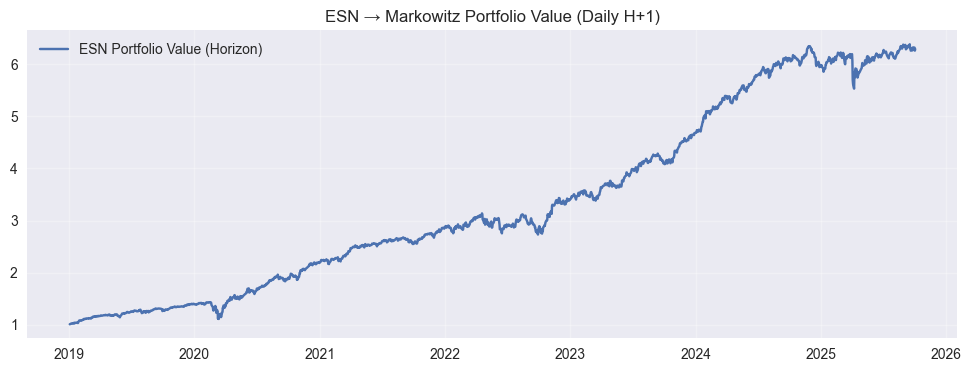

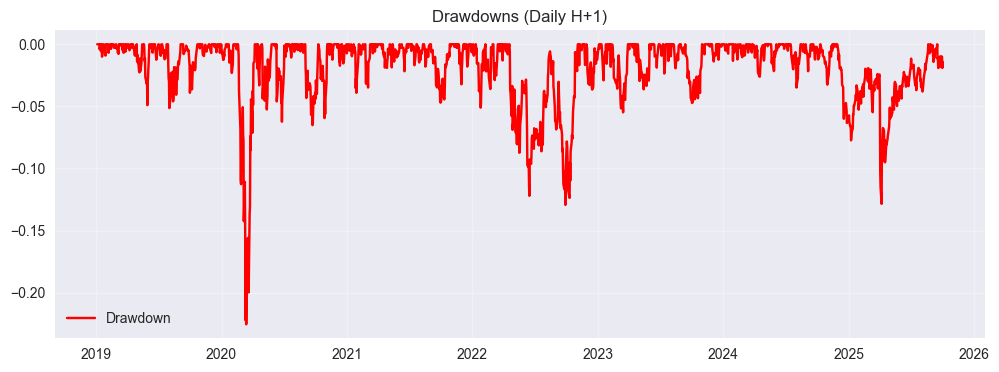

In [7]:
# ------------------------------------------------------------
# 5.1 Performance Metrics & Portfolio Value (Daily H+1)
# ------------------------------------------------------------
step_ret = results_esn["ret_real"].fillna(0.0)
portfolio = (1 + step_ret).cumprod()

def max_drawdown(series: pd.Series):
    roll_max = series.cummax()
    dd = series / roll_max - 1.0
    return dd.min(), dd

total_return = portfolio.iloc[-1] - 1.0
vol         = step_ret.std() * np.sqrt(252)
sharpe      = step_ret.mean() / step_ret.std() * np.sqrt(252)
sortino     = step_ret.mean() / step_ret[step_ret < 0].std() * np.sqrt(252)
mdd, dd     = max_drawdown(portfolio)

print("=== ESN→Markowitz (Horizon-level metrics) ===")
print("Total return:", total_return)
print("Annualized vol:", vol)
print("Sharpe:", sharpe)
print("Sortino:", sortino)
print("Max Drawdown:", mdd)

# value (horizon grid)
plt.figure(figsize=(12,4))
plt.plot(results_esn.index, portfolio, label="ESN Portfolio Value (Horizon)")
plt.grid(alpha=0.3)
plt.legend()
plt.title("ESN → Markowitz Portfolio Value (Daily H+1)")
plt.show()

# drawdown (horizon grid) 5.2 Drawdown Analysis (Daily H+1)
plt.figure(figsize=(12,4))
plt.plot(results_esn.index, dd, color="red", label="Drawdown")
plt.grid(alpha=0.3)
plt.legend()
plt.title("Drawdowns (Daily H+1)")
plt.show()

In [8]:
# ============================================================
# 6. CONVERT ESN PORTFOLIO TO MONTHLY (for fair comparison)
# ============================================================

# Το 'portfolio' είναι DAILY value index (Daily H+1)
portfolio_esn_daily = portfolio.copy() # Το 'portfolio' είναι DAILY value index (Daily H+1)
portfolio_esn_monthly = portfolio_esn_daily.resample("ME").last().dropna() # month-end
r_esn_monthly = portfolio_esn_monthly.pct_change().dropna() # Monthly returns ESN

total_return_esn = portfolio_esn_monthly.iloc[-1] / portfolio_esn_monthly.iloc[0] - 1.0 # Recompute ESN metrics σε μηνιαία βάση (ώστε να είναι comparable με EW/IVOL/MVP)
vol_esn          = r_esn_monthly.std() * np.sqrt(12)
sharpe_esn       = r_esn_monthly.mean() / r_esn_monthly.std() * np.sqrt(12)
sortino_esn      = r_esn_monthly.mean() / r_esn_monthly[r_esn_monthly < 0].std() * np.sqrt(12)
mdd_esn, dd_esn  = max_drawdown(portfolio_esn_monthly)

print("=== ESN (monthly) metrics ===")
print("Total return (ESN, monthly):", total_return_esn)
print("Annualized vol (ESN, monthly):", vol_esn)
print("Sharpe (ESN, monthly):", sharpe_esn)
print("Sortino (ESN, monthly):", sortino_esn)
print("Max Drawdown (ESN, monthly):", mdd_esn)
print("ESN monthly start:", portfolio_esn_monthly.index[0])

=== ESN (monthly) metrics ===
Total return (ESN, monthly): 4.859114917559982
Annualized vol (ESN, monthly): 0.13467867120986662
Sharpe (ESN, monthly): 2.0307708798491175
Sortino (ESN, monthly): 5.069175686715884
Max Drawdown (ESN, monthly): -0.07399010071866108
ESN monthly start: 2019-01-31 00:00:00


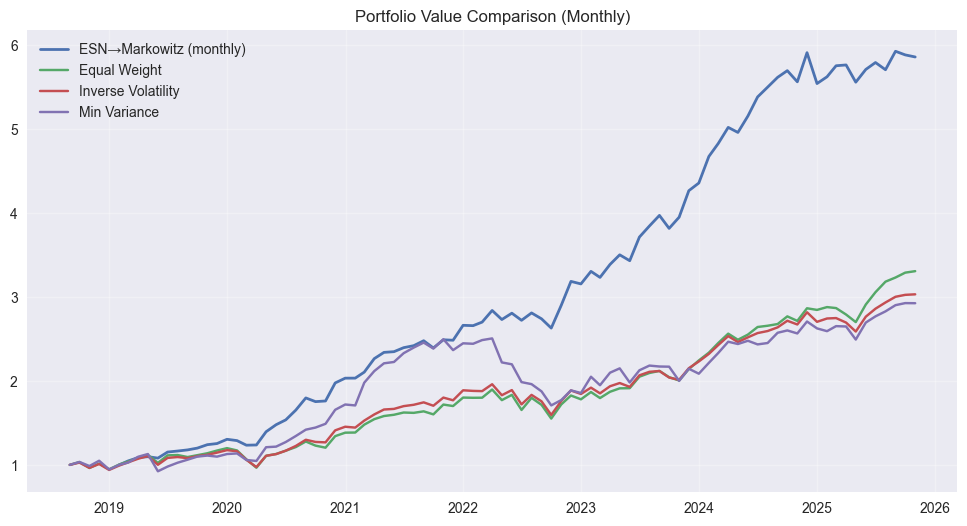

In [9]:
# ============================================================
# 7. CLASSIC STRATEGIES (EW / IVOL / MVP) — CONSISTENT VERSION
# ============================================================
def run_strategy(retm_assets, method="EW", lookback=6):

    cols = retm_assets.columns
    eq = []
    weights_rec = []
    idx_list = []

    for t in range(lookback, len(retm_assets)):
        window = retm_assets.iloc[t-lookback:t]

        if method == "EW":
            w = np.ones(len(cols)) / len(cols)

        elif method == "IVOL":
            vol = window.std(ddof=0)
            inv = 1 / vol.replace(0, np.nan)
            w = (inv / inv.sum()).fillna(0.0).values

        elif method == "MVP":
            Sigma = window.cov(ddof=0).values
            Sigma = make_psd(Sigma)

            n = len(cols)
            w_var = cp.Variable(n)

            prob = cp.Problem(
                cp.Minimize(cp.quad_form(w_var, Sigma)),
                [cp.sum(w_var) == 1, w_var >= 0]
            )
            prob.solve(solver=cp.SCS)

            w = np.array(w_var.value).ravel()

        r = retm_assets.iloc[t].values
        port_ret = float(r @ w)

        eq.append((eq[-1] if eq else 1.0) * (1 + port_ret))

        weights_rec.append(w)
        idx_list.append(retm_assets.index[t])

    eq = pd.Series(eq, index=idx_list)
    weights_df = pd.DataFrame(weights_rec, index=idx_list, columns=cols)

    return eq, weights_df

LOOKBACK_MONTHS = 6

eq_ew,   w_ew   = run_strategy(retm_assets, "EW", LOOKBACK_MONTHS)
eq_ivol, w_ivol = run_strategy(retm_assets, "IVOL", LOOKBACK_MONTHS)
eq_mvp,  w_mvp  = run_strategy(retm_assets, "MVP", LOOKBACK_MONTHS)

# ============================================================
# 8. PLOT COMPARISON - ESN (monthly) vs EW / IVOL / MVP
# ============================================================
plt.figure(figsize=(12,6))
plt.plot(portfolio_esn_monthly.index,portfolio_esn_monthly / portfolio_esn_monthly.iloc[0],label="ESN→Markowitz (monthly)", lw=2)
plt.plot(eq_ew.index,   eq_ew/eq_ew.iloc[0],   label="Equal Weight")
plt.plot(eq_ivol.index, eq_ivol/eq_ivol.iloc[0], label="Inverse Volatility")
plt.plot(eq_mvp.index,  eq_mvp/eq_mvp.iloc[0],  label="Min Variance")
plt.legend()
plt.grid(alpha=0.3)
plt.title("Portfolio Value Comparison (Monthly)")
plt.show()

In [ ]:
# ============================================================
# TURNOVER — BASELINE STRATEGIES (EW / IVOL / MVP)
# ============================================================
def compute_turnover(w_df):
    return 0.5 * w_df.diff().abs().sum(axis=1)

# ============================================================
# 1) MONTHLY TURNOVER (natural frequency)
# ============================================================

to_ew_m   = compute_turnover(w_ew)
to_ivol_m = compute_turnover(w_ivol)
to_mvp_m  = compute_turnover(w_mvp)

turnover_monthly = pd.DataFrame({
    "EW": to_ew_m,
    "IVOL": to_ivol_m,
    "MVP": to_mvp_m
})

# ============================================================
# 2) DAILY TURNOVER
# ============================================================

daily_index = df.index

w_ew_d   = w_ew.reindex(daily_index).ffill()
w_ivol_d = w_ivol.reindex(daily_index).ffill()
w_mvp_d  = w_mvp.reindex(daily_index).ffill()

to_ew_d   = compute_turnover(w_ew_d)
to_ivol_d = compute_turnover(w_ivol_d)
to_mvp_d  = compute_turnover(w_mvp_d)

turnover_daily = pd.DataFrame({
    "EW": to_ew_d,
    "IVOL": to_ivol_d,
    "MVP": to_mvp_d
})

# ============================================================
# 3) SUMMARY TABLE (IN %)
# ============================================================

turnover_summary = pd.DataFrame({
    "TO % (Daily)": turnover_daily.mean()*100,
    "TO % (Monthly)": turnover_monthly.mean()*100,
    "Ann TO % (from Daily)": turnover_daily.mean()*252*100,
    "Ann TO % (from Monthly)": turnover_monthly.mean()*12*100
}).round(2)

# ============================================================
# PRINTS
# ============================================================

print("\n" + "="*55)
print("BASELINE STRATEGIES — TURNOVER SUMMARY (%)")
print("="*55)

print("\nAverage Turnover:")
print("-"*55)
print(turnover_summary)


BASELINE STRATEGIES — TURNOVER SUMMARY (%)

Average Turnover:
-------------------------------------------------------
      TO % (Daily)  TO % (Monthly)  Ann TO % (from Daily)  \
EW            0.00            0.00                   0.00   
IVOL          0.28            7.56                  70.37   
MVP           1.31           35.64                 329.63   

      Ann TO % (from Monthly)  
EW                       0.00  
IVOL                    90.76  
MVP                    427.63  


In [11]:
# ============================================================
# PERFORMANCE TABLE (Monthly frequency)
# ============================================================
def perf_metrics(eq: pd.Series):
    r = eq.pct_change().dropna()

    total   = eq.iloc[-1] / eq.iloc[0] - 1
    vol     = r.std() * np.sqrt(12)
    sharpe  = r.mean() / r.std() * np.sqrt(12)
    sortino = r.mean() / r[r < 0].std() * np.sqrt(12)
    mdd     = (eq / eq.cummax() - 1).min()

    return total, vol, sharpe, sortino, mdd

strategies = {
    "ESN→Markowitz": portfolio_esn_monthly,
    "Equal Weight":   eq_ew,
    "Inverse Vol":    eq_ivol,
    "Min Variance":   eq_mvp
}

rows = {}

for name, eq in strategies.items():
    rows[name] = perf_metrics(eq)

summary = pd.DataFrame.from_dict(
    rows,
    orient="index",
    columns=[
        "Total Return",
        "Volatility",
        "Sharpe",
        "Sortino",
        "Max Drawdown"]).round(4)

summary

,Total Return,Volatility,Sharpe,Sortino,Max Drawdown
ESN→Markowitz,4.8591,0.1347,2.0308,5.0692,-0.0740
Equal Weight,2.3078,0.1666,1.0911,1.6868,-0.1945
Inverse Vol,2.0319,0.1594,1.0560,1.6104,-0.1863
Min Variance,1.9260,0.1918,0.8816,1.1468,-0.3183


In [12]:
def daily_equity_from_monthly_weights(daily_ret, monthly_w):

    # shift weights to start applying AFTER rebalance date
    w_shifted = monthly_w.shift(1)

    # expand to daily index
    w_daily = w_shifted.reindex(daily_ret.index, method="ffill")

    # drop days before first weight exists
    common_idx = daily_ret.index.intersection(w_daily.dropna().index)

    daily_ret = daily_ret.loc[common_idx]
    w_daily   = w_daily.loc[common_idx]

    eq = []
    val = 1.0

    for t in daily_ret.index:
        w = w_daily.loc[t].values
        r = daily_ret.loc[t].values

        port_ret = float(w @ r)
        val *= (1 + port_ret)
        eq.append(val)

    return pd.Series(eq, index=daily_ret.index)

eq_ew_daily   = daily_equity_from_monthly_weights(rets_all, w_ew)
eq_ivol_daily = daily_equity_from_monthly_weights(rets_all, w_ivol)
eq_mvp_daily  = daily_equity_from_monthly_weights(rets_all, w_mvp)

EW Max DD: -0.3180206668413875
IVOL Max DD: -0.3111660739504205
MVP Max DD: -0.23911776043455912


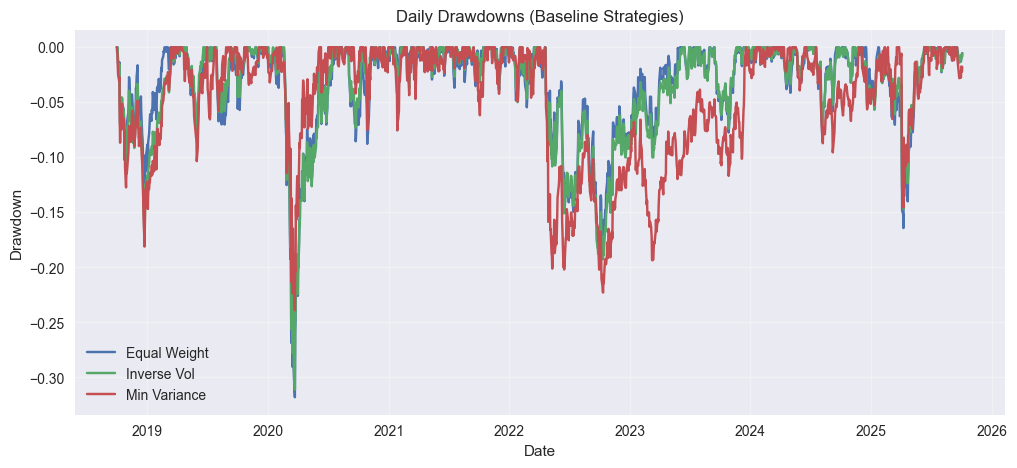

In [13]:
# ============================================================
# DAILY DRAWDOWNS FOR BASELINE STRATEGIES
# ============================================================

def max_drawdown(series: pd.Series):
    roll_max = series.cummax()
    dd = series / roll_max - 1.0
    return dd.min(), dd


# --- Compute DD series ---
mdd_ew,   dd_ew   = max_drawdown(eq_ew_daily)
mdd_ivol, dd_ivol = max_drawdown(eq_ivol_daily)
mdd_mvp,  dd_mvp  = max_drawdown(eq_mvp_daily)

print("EW Max DD:", mdd_ew)
print("IVOL Max DD:", mdd_ivol)
print("MVP Max DD:", mdd_mvp)


# --- Plot daily drawdowns ---
plt.figure(figsize=(12,5))
plt.plot(dd_ew.index,   dd_ew,   label="Equal Weight")
plt.plot(dd_ivol.index, dd_ivol, label="Inverse Vol")
plt.plot(dd_mvp.index,  dd_mvp,  label="Min Variance")

plt.legend()
plt.grid(alpha=0.3)
plt.title("Daily Drawdowns (Baseline Strategies)")
plt.ylabel("Drawdown")
plt.xlabel("Date")
plt.show()


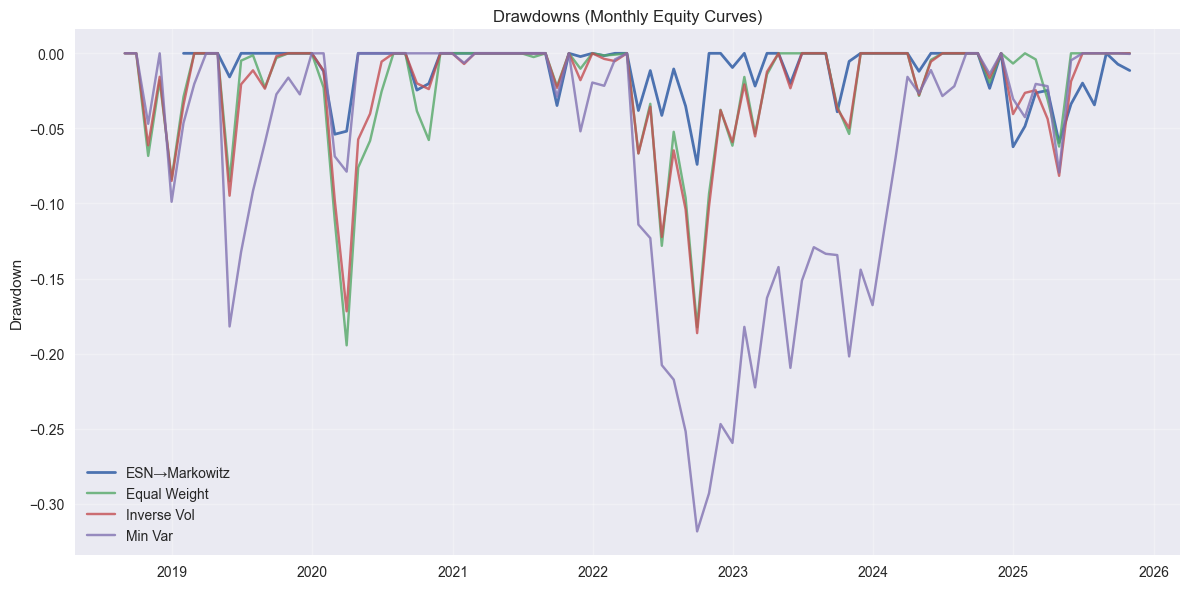

In [ ]:
# ============================================================
# X3. Drawdowns Comparison (ESN vs EW / IVOL / MVP)
# ============================================================

def drawdown_series(eq: pd.Series) -> pd.Series:
    roll_max = eq.cummax()
    dd = eq / roll_max - 1.0
    return dd

dd_esn_m  = drawdown_series(portfolio_esn_monthly)
dd_ew     = drawdown_series(eq_ew)
dd_ivol   = drawdown_series(eq_ivol)
dd_mvp    = drawdown_series(eq_mvp)

plt.figure(figsize=(12,6))
plt.plot(dd_esn_m.index, dd_esn_m,  label="ESN→Markowitz", lw=2)
plt.plot(dd_ew.index,    dd_ew,     label="Equal Weight", alpha=0.8)
plt.plot(dd_ivol.index,  dd_ivol,   label="Inverse Vol",  alpha=0.8)
plt.plot(dd_mvp.index,   dd_mvp,    label="Min Var",      alpha=0.8)

plt.title("Drawdowns (Monthly Equity Curves)")
plt.ylabel("Drawdown")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# ---------------- SAVE: EQUITY CURVES ----------------
df_eq = pd.concat([
    portfolio_esn_monthly.rename("ESN_Model1"),
    eq_ew.rename("EW"),
    eq_ivol.rename("IVOL"),
    eq_mvp.rename("MVP")
], axis=1)

df_eq.to_csv(r"E:\data\Model1_data\equity_curves_monthly.csv", index_label="date")
df_eq

,ESN_Model1,EW,IVOL,MVP
2018-08-31,NaN,1.022298,1.029402,1.044997
2018-09-30,NaN,1.057340,1.057416,1.081762
2018-10-31,NaN,0.985129,0.992650,1.030988
2018-11-30,NaN,1.038227,1.040884,1.096703
2018-12-31,NaN,0.968780,0.967565,0.988280
...,...,...,...,...
2025-06-30,6.222587,3.125413,2.944709,2.893980
2025-07-31,6.130357,3.253611,3.021108,2.956056
2025-08-31,6.366471,3.304119,3.090866,3.033362
2025-09-30,6.320360,3.363319,3.114495,3.058891


In [15]:
# ---------------- SAVE: RETURNS ----------------
# Compute monthly returns for baselines
r_ew   = eq_ew.pct_change().dropna()
r_ivol = eq_ivol.pct_change().dropna()
r_mvp  = eq_mvp.pct_change().dropna()

df_ret = pd.concat([
    r_esn_monthly.rename("ESN_Model1"),
    r_ew.rename("EW"),
    r_ivol.rename("IVOL"),
    r_mvp.rename("MVP")
], axis=1)

df_ret.to_csv(r"E:\data\Model1_data\returns_monthly.csv", index_label="date")
df_ret

,ESN_Model1,EW,IVOL,MVP
2018-09-30,NaN,0.034277,0.027214,0.035182
2018-10-31,NaN,-0.068295,-0.061249,-0.046937
2018-11-30,NaN,0.053899,0.048591,0.063740
2018-12-31,NaN,-0.066889,-0.070439,-0.098862
2019-01-31,NaN,0.059764,0.055299,0.058272
...,...,...,...,...
2025-06-30,0.014448,0.050508,0.034424,0.027462
2025-07-31,-0.014822,0.041018,0.025944,0.021450
2025-08-31,0.038516,0.015524,0.023090,0.026152
2025-09-30,-0.007243,0.017917,0.007645,0.008416


In [ ]:
# ---------------- SAVE: DRAWDOWNS ----------------
dd_df = pd.concat([
    dd_esn_m.rename("ESN_Model1"),
    dd_ew.rename("EW"),
    dd_ivol.rename("IVOL"),
    dd_mvp.rename("MVP")
], axis=1)

dd_df.to_csv(r"E:\data\Model1_data\drawdowns_monthly.csv", index_label="date")
dd_df

,ESN_Model1,EW,IVOL,MVP
2018-08-31,NaN,0.000000,0.000000,0.000000
2018-09-30,NaN,0.000000,0.000000,0.000000
2018-10-31,NaN,-0.068295,-0.061249,-0.046937
2018-11-30,NaN,-0.018077,-0.015634,0.000000
2018-12-31,NaN,-0.083757,-0.084972,-0.098862
...,...,...,...,...
2025-06-30,-0.019832,0.000000,0.000000,0.000000
2025-07-31,-0.034360,0.000000,0.000000,0.000000
2025-08-31,0.000000,0.000000,0.000000,0.000000
2025-09-30,-0.007243,0.000000,0.000000,0.000000


In [ ]:
weights_df = pd.DataFrame(results_esn["weights"].tolist(),index=results_esn.index)
weights_df.to_csv(r"E:\data\Model1_data\weights_esn_model1_monthly.csv",index_label="date")
weights_df.head()

,VOO,MSFT,AMZN,AVGO,VZ,XOM,CVX,CAT,SCHD,PG
date,,,,,,,,,,
2019-01-04,0.2,0.106297,0.030696,0.074138,0.200000,0.200000,0.111213,-0.101316,-0.021028,0.2
2019-01-07,0.2,-0.074125,0.049473,0.034980,0.200000,0.200000,0.082815,-0.093145,0.200000,0.2
2019-01-08,0.2,-0.045204,-0.043729,0.126258,0.166987,0.108688,0.100945,-0.013945,0.200000,0.2
2019-01-09,0.2,-0.067786,0.042872,0.035289,0.200000,0.200000,0.082581,-0.092956,0.200000,0.2
2019-01-10,0.2,-0.075987,0.044220,0.038661,0.200000,0.200000,0.081761,-0.088653,0.200000,0.2
